In [25]:
import pathlib
import random
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from skimage import io as skio
from skimage import transform
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from dataset_utils import mk_dataset


In [26]:
def gends(ds_root, suffix, batch_size):
    ds_root = pathlib.Path(ds_root)
    pathlist = ds_root.glob(f"map/*.{suffix}")
    pathlist = sorted([path.name for path in pathlist])
    sat_pathlist = sorted([str(ds_root / "sat" / path) for path in pathlist])
    map_pathlist = sorted([str(ds_root / "map" / path) for path in pathlist])
    test_ds = mk_dataset.mkds(
        sat_pathlist, map_pathlist, batch_size=batch_size, test=True
    )
    return test_ds


def show_results(images, titles, figsize=(20, 20)):
    nb_images = len(images)
    plt.figure(figsize=figsize)
    for idx, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) and image.shape[-1] == 1:
            image = image[..., 0]
        plt.subplot(1, nb_images, idx + 1)
        plt.title(title)
        plt.imshow(image, cmap="gray")
    plt.show()


In [27]:
class Augment(layers.Layer):
    def __init__(
        self,
        zoom_rate: Optional[Tuple[float,float]]=None,
        flip_mode: Optional[str]=None,
        rotate_rate: Optional[float]=None,
        trans_rate:  Optional[float]=None,
        hue:         Optional[float]=None,
        brightness:  Optional[float]=None,
        contrast:    Optional[float]=None,

    ):
        super().__init__()

        seed = 99
        interpolation = "nearest"

        self.hue = hue
        self.brightness = brightness

        self.inputs_augment = keras.models.Sequential(name='inputs_augment')
        self.labels_augment = keras.models.Sequential(name='labels_augment')
        # fmt:off
        if zoom_rate is not None:
            self.inputs_augment.add(preprocessing.RandomZoom(zoom_rate, interpolation='bilinear', seed=seed))
            self.labels_augment.add(preprocessing.RandomZoom(zoom_rate, interpolation='bilinear', seed=seed))

        if flip_mode is not None:
            self.inputs_augment.add(preprocessing.RandomFlip(flip_mode, seed=seed))
            self.labels_augment.add(preprocessing.RandomFlip(flip_mode, seed=seed))

        if rotate_rate is not None:
            self.inputs_augment.add(preprocessing.RandomRotation(rotate_rate,  interpolation=interpolation, seed=seed))
            self.labels_augment.add(preprocessing.RandomRotation(rotate_rate,  interpolation=interpolation, seed=seed))

        if trans_rate is not None:
            self.inputs_augment.add(preprocessing.RandomTranslation(trans_rate, trans_rate, interpolation=interpolation, seed=seed))
            self.labels_augment.add(preprocessing.RandomTranslation(trans_rate, trans_rate, interpolation=interpolation, seed=seed))

        if contrast is not None:
            self.inputs_augment.add(preprocessing.RandomContrast(factor=contrast))
       # fmt:on

    def call(self, inputs, labels):
        inputs = self.inputs_augment(inputs)
        labels = self.labels_augment(labels)
        if self.brightness is not None:
            inputs = tf.image.random_brightness(inputs, max_delta=self.brightness)
        if self.hue is not None:
            inputs = tf.image.random_hue(inputs, max_delta=self.hue)


        return inputs, labels


In [87]:
augment = Augment(
    flip_mode="horizontal_and_vertical",
    zoom_rate=(-0.3, 0),
    rotate_rate=0.2, 
    hue=0.2,
    brightness=0.2,
    contrast=0.2,
)

In [29]:

layer1 = preprocessing.RandomZoom((-0.3, 0), seed=42)
layer2 = preprocessing.RandomZoom((-0.3, 0), seed=42)

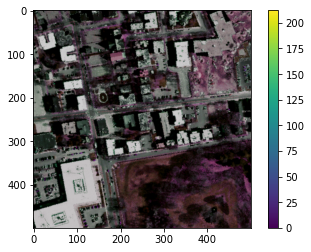

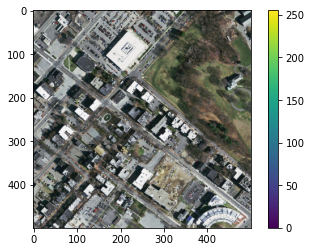

In [99]:
path = "/Users/hagayuya/Datasets/mass_roads9/valid/sat/10978735_15_3_1_2.png"
inp = skio.imread(path)[None]
path = "/Users/hagayuya/Datasets/mass_roads9/valid/map/10978735_15_3_1_2.png"
tar = skio.imread(path, as_gray=True)[None, ..., None]
with tf.device(":/cpu"):
    aug_inp, aug_tar = augment(inp, tar)
plt.imshow(aug_inp[0])
plt.colorbar()
plt.show()

plt.imshow(inp[0])
plt.colorbar()
plt.show()


In [31]:
augment = Augment(
    flip_mode="horizontal_and_vertical",
    zoom_rate=0.2,
    rotate_rate=0.2,
    trans_rate=0.2,
)


ds_root = pathlib.Path("../../DataSets/mass_roads256/test")
suffix = "png"
batch_size = 32
dsrate = 0.25

nbmix = 3

(
    ((tr_sat_pathlist, tr_map_pathlist), tr_steps),
    ((va_sat_pathlist, va_map_pathlist), va_steps),
) = mk_dataset.mk_pathlist(
    ds_root,
    suffix,
    batch_size=batch_size,
    dsrate=dsrate,
)

train_ds = mk_dataset.mkds(
    tr_sat_pathlist,
    tr_map_pathlist,
    # augment=augment,
    batch_size=batch_size,
)


In [32]:
inp, tar = next(iter(train_ds))


2022-01-13 11:37:33.343165: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-13 11:37:33.445051: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


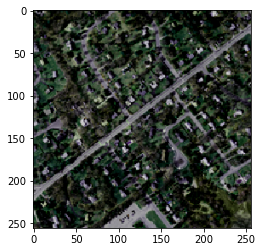

In [33]:
image = inp[0]
mapim = tar[0]

image = tf.image.random_hue(image, max_delta=0.2)
image = tf.image.random_brightness(image, max_delta=0.2)
# image = tf.image.random_saturation(image, 0, 10)

plt.imshow(image)


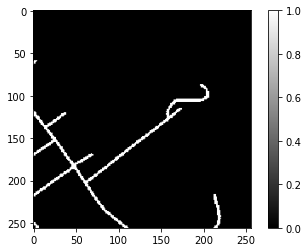

In [34]:
import matplotlib.pyplot as plt

plt.imshow(tar[1], cmap="gray")
plt.colorbar()
plt.show()


In [35]:
with tf.device("/:cpu0"):
    result = tf.keras.layers.RandomCrop(10, 10)(np.zeros((1, 28, 28, 1)))
result.shape


TensorShape([1, 10, 10, 1])